# Plant Leaf Disease Detection
Mayur Kr. Garg

## Imports

In [48]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from model_utility import plot_images
from keras.src.callbacks import EarlyStopping, TensorBoard
from keras.src.utils import load_img, img_to_array
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.utils import plot_model

In [49]:
tf.__version__

'2.16.1'

In [50]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[]

In [51]:
tf.get_logger().setLevel('ERROR')

## Constants

### Data

In [52]:
BASE_DIR = "datasets"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR = os.path.join(BASE_DIR, "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64

### Model

In [53]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

### Training

In [54]:
EPOCHS = 30
PATIENCE = 5
QUEUE_SIZE = 25
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

## Data Loading

### Data Distribution

#### Train

In [55]:
total_train = 0

for dir in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, dir)
    img_count = len(os.listdir(path))
    total_train += img_count
    print(f'{dir:50} : {img_count}')

print(f'\nTotal training images: {total_train}')

Apple leaf_Black rot                               : 1987
Apple leaf_Healthy                                 : 511
Apple leaf_Rust                                    : 1840
Apple leaf_Scab                                    : 2099
Bell Pepper leaf_Bacterial spot                    : 1975
Bell Pepper leaf_Healthy                           : 2041
Bell Pepper leaf_Spot                              : 9
Blueberry leaf_Healthy                             : 465
Cherry leaf_Healthy                                : 1873
Cherry leaf_Powdery mildew                         : 1683
Corn leaf_Blight                                   : 2090
Corn leaf_Gray spot                                : 1706
Corn leaf_Healthy                                  : 1859
Corn leaf_Rust                                     : 2013
Grape leaf_Black measles                           : 1920
Grape leaf_Black rot                               : 1944
Grape leaf_Blight                                  : 1722
Grape leaf_Healthy 

#### Validation

In [56]:
total_val = 0

for dir in os.listdir(VAL_DIR):
    path = os.path.join(VAL_DIR, dir)
    img_count = len(os.listdir(path))
    total_val += img_count
    print(f'{dir:50} : {img_count}')

print(f'\nTotal validation images: {total_val}')

Apple leaf_Black rot                               : 497
Apple leaf_Healthy                                 : 511
Apple leaf_Rust                                    : 449
Apple leaf_Scab                                    : 514
Bell Pepper leaf_Bacterial spot                    : 478
Bell Pepper leaf_Healthy                           : 505
Bell Pepper leaf_Spot                              : 9
Blueberry leaf_Healthy                             : 465
Cherry leaf_Healthy                                : 466
Cherry leaf_Powdery mildew                         : 421
Corn leaf_Blight                                   : 488
Corn leaf_Gray spot                                : 414
Corn leaf_Healthy                                  : 465
Corn leaf_Rust                                     : 487
Grape leaf_Black measles                           : 480
Grape leaf_Black rot                               : 480
Grape leaf_Blight                                  : 430
Grape leaf_Healthy               

#### Test

In [57]:
test_image_data = []
test_image_filenames = []

for img_name in os.listdir(TEST_DIR):
    img = load_img(os.path.join(TEST_DIR, img_name), target_size = IMG_SHAPE)
    test_image_data.append(img_to_array(img, dtype = 'uint8'))
    test_image_filenames.append(img_name)
    print(img_name)
    
test_image_data = np.array(test_image_data)/255
print(f'\nTotal testing images: {len(test_image_data)}')

0001.JPG
0002.JPG
0003.JPG
0004.JPG
0005.JPG
0006.JPG
0007.JPG

Total testing images: 7


### Image Generators

#### Train

In [58]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 67621 images belonging to 40 classes.


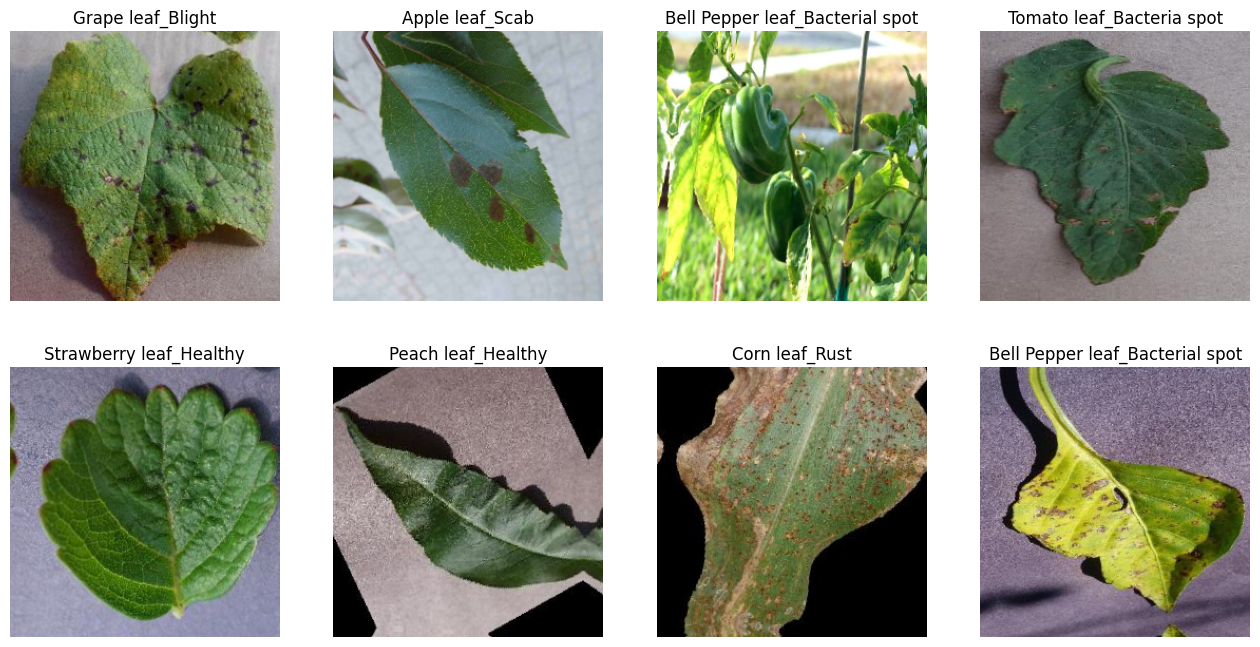

In [59]:
plot_images(train_data_gen)

#### Validation

In [60]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 16863 images belonging to 40 classes.


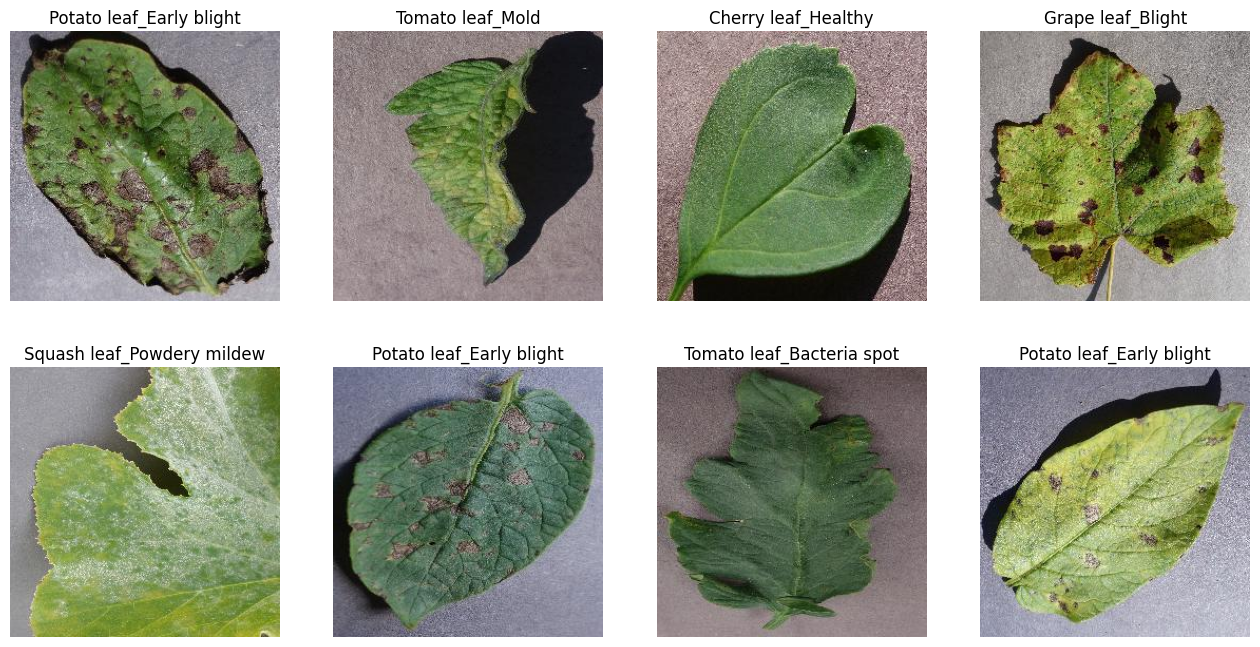

In [61]:
plot_images(val_data_gen)

### Class lookup dictionary

In [62]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 40


In [63]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple leaf_Black rot
 1 : Apple leaf_Healthy
 2 : Apple leaf_Rust
 3 : Apple leaf_Scab
 4 : Bell Pepper leaf_Bacterial spot
 5 : Bell Pepper leaf_Healthy
 6 : Bell Pepper leaf_Spot
 7 : Blueberry leaf_Healthy
 8 : Cherry leaf_Healthy
 9 : Cherry leaf_Powdery mildew
10 : Corn leaf_Blight
11 : Corn leaf_Gray spot
12 : Corn leaf_Healthy
13 : Corn leaf_Rust
14 : Grape leaf_Black measles
15 : Grape leaf_Black rot
16 : Grape leaf_Blight
17 : Grape leaf_Healthy
18 : Peach leaf_Bacterial spot
19 : Peach leaf_Early blight
20 : Peach leaf_Healthy
21 : Peach leaf_Late blight
22 : Potato leaf_Early blight
23 : Potato leaf_Healthy
24 : Potato leaf_Late blight
25 : Raspberry leaf_Healthy
26 : Soyabean leaf_Healthy
27 : Squash leaf_Powdery mildew
28 : Strawberry leaf_Healthy
29 : Strawberry leaf_Scorch
30 : Tomato leaf_Bacteria spot
31 : Tomato leaf_Early blight
32 : Tomato leaf_Healthy
33 : Tomato leaf_Late blight
34 : Tomato leaf_Mold
35 : Tomato leaf_Mosaic virus
36 : Tomato leaf_Septoria spo

## Model

### Input Layer

In [64]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

(None, 256, 256, 3)

### Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

#### Block 1

In [65]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

(None, 256, 256, 24)

In [66]:
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

(None, 256, 256, 32)

In [67]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

(None, 128, 128, 32)

#### Block 2

In [68]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

(None, 128, 128, 32)

In [69]:
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

(None, 128, 128, 64)

In [70]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

(None, 64, 64, 64)

#### Block 3

In [71]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

(None, 64, 64, 64)

In [72]:
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

(None, 64, 64, 128)

In [73]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

(None, 32, 32, 128)

#### Block 4

In [74]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

(None, 32, 32, 128)

In [75]:
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

(None, 32, 32, 256)

In [76]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

(None, 16, 16, 256)

#### Block 5

In [77]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

(None, 16, 16, 256)

In [78]:
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

(None, 16, 16, 512)

In [79]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

(None, 8, 8, 512)

### Global Average Pooling layers for each block

In [80]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

(None, 32)

In [81]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

(None, 64)

In [82]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

(None, 128)

In [83]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

(None, 256)

In [84]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

(None, 512)

### Concatenation Layer

In [85]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

(None, 992)

### Dropout and Dense Layers

In [86]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

(None, 992)

In [87]:
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

(None, 512)

In [88]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

(None, 512)

In [89]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

(None, 40)

### Model Summary

In [90]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "Plant_Leaf"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_1               │ (None, 256, 256,  │        120 │ Input[0][0]       │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_1 (Conv2D)      │ (None, 256, 256,  │        800 │ DwC_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_1 (MaxPooling2D) │ (None, 128, 128,  │          0 │ PwC_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_2               │ (None, 128, 128,  │        160 │ MP_1[0][0]        │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_2 (Conv2D)      │ (None, 128, 128,  │      2,112 │ DwC_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_2 (MaxPooling2D) │ (None, 64, 64,    │          0 │ PwC_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_3               │ (None, 64, 64,    │        320 │ MP_2[0][0]        │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_3 (Conv2D)      │ (None, 64, 64,    │      8,320 │ DwC_3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_3 (MaxPooling2D) │ (None, 32, 32,    │          0 │ PwC_3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_4               │ (None, 32, 32,    │        640 │ MP_3[0][0]        │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_4 (Conv2D)      │ (None, 32, 32,    │     33,024 │ DwC_4[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_4 (MaxPooling2D) │ (None, 16, 16,    │          0 │ PwC_4[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_5               │ (None, 16, 16,    │      1,280 │ MP_4[0][0]        │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_5 (Conv2D)      │ (None, 16, 16,    │    131,584 │ DwC_5[0][0]       │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_5 (MaxPooling2D) │ (None, 8, 8, 512) │          0 │ PwC_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GAP_1               │ (None, 32)        │          0 │ MP_1[0][0]        │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 707,296 (2.70 MB)

 Trainable params: 707,296 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
plot_model(model, to_file = 'plots/model.jpg', show_shapes = True, dpi = PLOTS_DPI)

AttributeError: module 'pydot' has no attribute 'InvocationException'

## Training

### Callbacks

In [92]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

### History

In [93]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    callbacks = [earlyStop, tensorBoard]
)

Epoch 1/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1567s 1s/step - accuracy: 0.1022 - loss: 3.2986 - val_accuracy: 0.2401 - val_loss: 3.3009
Epoch 2/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1494s 1s/step - accuracy: 0.5014 - loss: 1.6999 - val_accuracy: 0.5093 - val_loss: 1.7153
Epoch 3/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1498s 1s/step - accuracy: 0.6771 - loss: 1.0738 - val_accuracy: 0.6960 - val_loss: 0.9920
Epoch 4/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1510s 1s/step - accuracy: 0.7661 - loss: 0.7866 - val_accuracy: 0.7363 - val_loss: 0.8935
Epoch 5/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1511s 1s/step - accuracy: 0.8243 - loss: 0.5977 - val_accuracy: 0.7700 - val_loss: 0.7536
Epoch 6/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1502s 1s/step - accuracy: 0.8548 - loss: 0.4882 - val_accuracy: 0.8174 - val_loss: 0.5671
Epoch 7/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1496s 1s/step - accuracy: 0.8753 - loss: 0.4194 - val_accuracy: 0.7942 - val_loss: 0.6574
Epoch 8/30
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 1530s 1s/step - accuracy: 0.8876 -

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alex0\\PycharmProjects\\fyp-ai\\plots\\acc_and_loss.jpg'

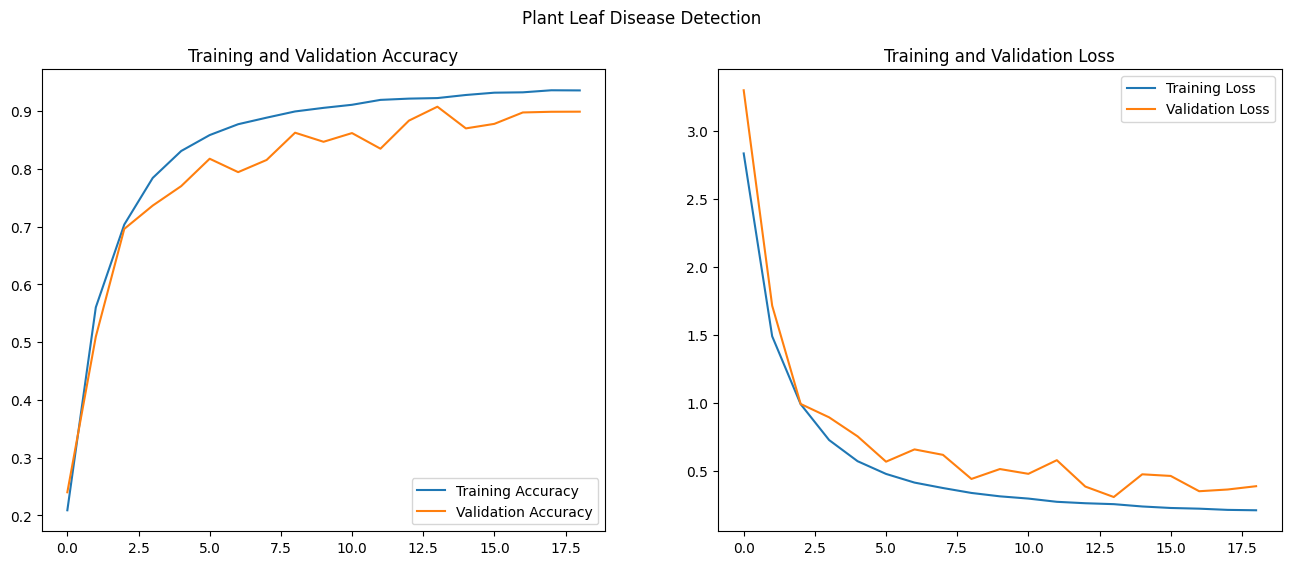

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Plant Leaf Disease Detection')

plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Evaluation

### Evaluating Test data

In [ ]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)
test_pred

In [ ]:
test_pred_classes = [class_name_lookup[i] for i in test_pred]

pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })

### Visualizing test data predictions

In [ ]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 15))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[i])
    plt.title(f"True: {test_image_filenames[i][:-4]}\nPrediction:{test_pred_classes[i]}")

plt.show()

### Confusion matrix for validation data

In [ ]:
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

In [ ]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Saving the model

In [99]:
model.save('models/plant_leaf_disease_detector.keras')